FASE 0: PREPARACIÓN

El sistema requiere de array, ast, glob, numpy, pandas, re (para descomponer los abstracts), shutil (para desempaquetar GloVe), scikit-learn (sklearn) y keras (tensorflow)

Comentado se encuentra una posible opción para tratar que tensorflow no utilize la GPU

In [97]:
import os
# Sin GPU
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"

#os.environ['CUDA_VISIBLE_DEVICES'] = '1'

from array import array
import ast
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from shutil import unpack_archive
import sklearn.model_selection
import tensorflow as tf



print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


Primero cargamos el conjunto de entrenamiento y test, en este caso de un .csv mediante pandas. Utilizamos una función de pandas para que se muestre todo.

Más tarde los dividimos en esos subconjuntos y lo comprobamos

In [98]:
pd.set_option('display.max_rows', None) # Se muestra todo
pd.set_option('display.max_columns', None) # Se muestra todo
x_dataframe = pd.read_csv('papers.csv') #tf.keras.datasets.mnist.load_data()

In [99]:
x_test, x_train = sklearn.model_selection.train_test_split(x_dataframe, test_size=0.9, train_size=0.1, random_state=None, shuffle=True, stratify=None)
# validación en el propio fit, validation_split = 0.1

print(f'Total shape: {str(x_dataframe.shape)} input {x_dataframe.keywords.shape} output') 
print(f'Training shape: {str(x_train.shape)} input {x_train.keywords.shape} output') # Estructura: 60k números de 28x28 
#print(x_train)
print(f'Test shape: {str(x_test.shape)} input {x_test.keywords.shape} output')
#print(x_test)
# TO-DO si son números divide para normalizar (divide por valor máximo)

# En keras pon capa de salida para problemas de multiclasifiación, los paso a cetegorical
# y_train = to_categorical(x_train, num_classes=600) #nos vuelve valor numérico en array ordenado donde se activa la neurona que corresponde con respuesta
# y_test = to_categorical(y_test, num_classes=600)
# to_one_hot # de pandas
# TO-DO dividir a parte de test y entrenamiento

Total shape: (448, 8) input (448,) output
Training shape: (404, 8) input (404,) output
Test shape: (44, 8) input (44,) output


Aquí es conveniente definir una función que a partir de un conjunto, pueda devolvernos las cadenas de título, abstract y palabras clave debidamente separadas en sus palabras. De esta forma se pueden sacar las palabras del conjunto de entrenamiento, test y cualquier conjunto futuro.

In [100]:
def extraerPalabrasDelConjunto (x_train, listaPalabras):
    listaTitlesTemp = x_train.title.tolist() # Listarlos
    listaTitlesPorArticulo = [] # Con esto sabemos cuales son de cada artículo
    listaTitles = [] # Con esto los pasamos a una lista de 1 nivel
  
    listaAbstractsTemp = x_train.abstract.tolist() # Listarlos
    listaAbstractsPorArticulo = [] # Con esto sabemos cuales son de cada artículo
    listaAbstracts = [] # Con esto los pasamos a una lista de 1 nivel

    listaKeywordsTemp = x_train.keywords.tolist() # Listarlos
    listaKeywordsPorArticulo = [] # Con esto sabemos cuales son de cada artículo
    listaKeywords = [] # Con esto los pasamos a una lista de 1 nivel    

    for valor in listaKeywordsTemp:
        #chunks = valor.split(',')
        chunks = re.split(',[ ]*',valor) # Son separados por comas, pero ignoramos los espacios antes de dichos tags
        listaKeywordsPorArticulo.append(chunks)
        for chunk in chunks:
            listaKeywords.append(chunk)
            listaPalabras.append(chunk)
        
    for valor in listaAbstractsTemp:
        chunks = re.split('[^a-zA-Z0-9]+',valor) # separo dejando solo caracteres normales
        listaAbstractsPorArticulo.append(chunks)
        for chunk in chunks:
            listaAbstracts.append(chunk)
            listaPalabras.append(chunk)
        
    for valor in listaTitlesTemp:
        chunks = re.split('[^a-zA-Z0-9]+',valor)
        listaTitlesPorArticulo.append(chunks)
        for chunk in chunks:
            listaTitles.append(chunk)
            listaPalabras.append(chunk)
            
    return listaTitlesPorArticulo, listaTitles, listaAbstractsPorArticulo, listaAbstracts, listaKeywordsPorArticulo, listaKeywords, listaPalabras

In [101]:
# Verifico que me sale lo mismo
listaPalabrasTotal = []
listaTitlesTotalPorArticulo, listaTotalTitles, listaTotalAbstractsPorArticulo, listaTotalAbstracts, listaTotalKeywordsPorArticulo, listaTotalKeywords, listaPalabrasTotal = extraerPalabrasDelConjunto (x_dataframe, listaPalabrasTotal)
print(len(listaPalabrasTotal))

listaPalabrasTrain = []
listaTitlesPorArticulo, listaTitles, listaAbstractsPorArticulo, listaAbstracts, listaKeywordsPorArticulo, listaKeywords, listaPalabrasEntrena = extraerPalabrasDelConjunto (x_train, listaPalabrasTrain)
print(len(listaPalabrasEntrena))
listaPalabrasTest = []
listaTestTitlesPorArticulo, listaTestTitles, listaTestAbstractsPorArticulo, listaTestAbstracts, listaTestKeywordsPorArticulo, listaTestKeywords, listaPalabrasTest = extraerPalabrasDelConjunto (x_test, listaPalabrasTest)
print(len(listaPalabrasTest))



77870
70599
7271


Es ahora cuando generamos una traducción de palabras obtenidas a valores que una red neuronal pueda entender, es decir, números.

El primer paso consiste en ordenar y quitarnos de en medio términos repetidos. Es posible que el utilizar mayúsculas en vez de minúsculas sea un diferenciador importante, por lo que términos con mismas letras pero capitalizados de forma diferente tengan un matiz de significado interesante.

También resulta interesante hacer lo mismo para las keywords obtenidas, así sabemos las dimensiones de salida más tarde

In [8]:
# Lo ordenamos
seenGenerico = list(set(listaPalabrasTotal))
#seenGenerico.sort()
otroTes = sorted(seenGenerico, key=str.lower)
#print(len(seenGenerico))
#print(seenGenerico)
print(len(otroTes))
print(otroTes)

9727
['', '0', '000', '0003', '01', '04', '05', '06', '09', '1', '10', '100', '1000', '100s', '101', '104', '106', '108', '109', '11', '116', '12', '120', '123', '13', '130', '14', '15', '153600', '16', '160', '1635', '17', '178', '18', '1833', '1874', '19', '1915', '1H', '2', '2-dim distance measure', '20', '2004', '2006', '2007', '2009', '2010', '2011', '2012', '2013', '2015', '2016', '2017', '2099', '21', '211', '216', '22', '23', '24', '243', '25', '250', '2586', '26', '27', '28', '29', '2D', '2d:4d', '2v1', '2v2', '3', '30', '31', '31m', '33', '34', '35', '3521', '36', '37', '39', '3960', '3d', '3D', '3d shapes', '3d-convnets', '3MW', '4', '40', '41', '410', '412', '42', '43', '44160', '47', '49', '4D', '4th', '5', '50', '500', '5000', '53', '54', '55', '56', '563', '59', '6', '60', '61', '63', '65', '67', '68', '7', '70', '72', '74', '75', '76', '77', '78', '79', '8', '80', '800', '81', '82', '83', '85', '86', '87', '88', '89', '9', '90', '901', '91', '92', '93', '94', '95', '97'

In [10]:
seenKeywords = list(set(listaTotalKeywords))
keywordsOrigin = sorted(seenKeywords, key=str.lower)
print(len(keywordsOrigin))
print(keywordsOrigin)

1534
['2-dim distance measure', '2d:4d', '3d shapes', '3d-convnets', 'abnormal event detection', 'academic success', 'accelerometer', 'accelerometer data', 'accelerometers', 'accreditation and assesments', 'accuracy', 'achievements information', 'acoustic feature learning', 'action bank features', 'activation function', 'active contour method', 'active learning', 'active set shrinking', 'activity detection', 'activity forecasting', 'activity recognition', 'adaptation method', 'adaptation models', 'adaptive approaches', 'adaptive learning', 'adaptive scheduling', 'adaptive threshold', 'adenoviral conjunctivitis (pink eye)', 'adversarial machine learning', 'afis', 'age', 'aggregated netflows', 'aggression', 'agriculture', 'air combat', 'algorithm', 'algorithm design and analysis', 'algorithm recognition', 'algorithm selection', "alzheimer's disease", "alzheimer's disease stage detection", 'american sign language', 'anaemia', 'anchored synchronization', 'android', 'anns', 'anomaly', 'anom

Ahora este resultado se debe guardar para un uso posterior. No debemos ejecutar las líneas de arriba de nuevo a menos que debamos corregir algo.

Tras leer del fichero, debemos crear el diccionario y un array adecuado para definir dichas palabras como números. Tambiñen es útil sacar los keywords para hacer lo mismo y optimizar el resultado de salida.

In [69]:
f = open("palabrasEntrada.txt", "w")
f.write(str(otroTes))
f.close()

In [52]:
f = open("keywordsIniciales.txt", "w")
f.write(str(keywordsOrigin))
f.close()

In [102]:
# FASE 1: Los de arriba ya no se vuelven a ejecutar, reabrimos y pasamos a lista
try:
    f = open("palabrasEntrada.txt", "r")
    cadenaMensaje = f.read()
except:
    print("FILE NOT FOUND!")
    cadenaMensaje = "ERROR"
finally:  
    res = ast.literal_eval(cadenaMensaje)
    print(len(res))

9727


In [103]:
try:
    f = open("keywordsIniciales.txt", "r")
    cadenaRetornoKeywords = f.read()
except:
    print("FILE NOT FOUND!")
    cadenaRetornoKeywords = "[]"
finally:  
    misKeywordsRetornadas = ast.literal_eval(cadenaRetornoKeywords)
    print(len(misKeywordsRetornadas))

1534


In [104]:
# * FASE 1.1 Creamos el diccionario
diccionarioLengua = dict()
'''
word_index = {word: (index + 3) for word, index in word_index.items()} 
word_index['<PAD>'] = 0  # Para padding
word_index['<SOS>'] = 1  # Para comienzo de sentencia
word_index['<UNK>'] = 2  # Para valores desconocidos
word_index['<UNU>'] = 3  # Para valores que no se usan
'''

diccionarioLengua["<UNU>"] = 0 # Establecemos el primero como valor vacio
diccionarioLengua["EsteValorEstaMuyDesconocido"] = 1 # Establecemos el segundo como valor desconocido
for i in range(0, len(res)):
    diccionarioLengua[res[i]] = i+2

print(diccionarioLengua)
print(len(diccionarioLengua))

{'<UNU>': 0, 'EsteValorEstaMuyDesconocido': 1, '': 2, '0': 3, '000': 4, '0003': 5, '01': 6, '04': 7, '05': 8, '06': 9, '09': 10, '1': 11, '10': 12, '100': 13, '1000': 14, '100s': 15, '101': 16, '104': 17, '106': 18, '108': 19, '109': 20, '11': 21, '116': 22, '12': 23, '120': 24, '123': 25, '13': 26, '130': 27, '14': 28, '15': 29, '153600': 30, '16': 31, '160': 32, '1635': 33, '17': 34, '178': 35, '18': 36, '1833': 37, '1874': 38, '19': 39, '1915': 40, '1H': 41, '2': 42, '2-dim distance measure': 43, '20': 44, '2004': 45, '2006': 46, '2007': 47, '2009': 48, '2010': 49, '2011': 50, '2012': 51, '2013': 52, '2015': 53, '2016': 54, '2017': 55, '2099': 56, '21': 57, '211': 58, '216': 59, '22': 60, '23': 61, '24': 62, '243': 63, '25': 64, '250': 65, '2586': 66, '26': 67, '27': 68, '28': 69, '29': 70, '2D': 71, '2d:4d': 72, '2v1': 73, '2v2': 74, '3': 75, '30': 76, '31': 77, '31m': 78, '33': 79, '34': 80, '35': 81, '3521': 82, '36': 83, '37': 84, '39': 85, '3960': 86, '3D': 87, '3d': 88, '3d sh

In [105]:
# * FASE 1.1 Creamos el diccionario
diccionarioKeywords = dict()
diccionarioKeywords["EsteValorEstaMuyDesconocido"] = 0 # Establecemos el primero como valor desconocido
for i in range(0, len(misKeywordsRetornadas)):
    diccionarioKeywords[misKeywordsRetornadas[i]] = i+1

print(diccionarioKeywords)
print(len(diccionarioKeywords))

{'EsteValorEstaMuyDesconocido': 0, '2-dim distance measure': 1, '2d:4d': 2, '3d shapes': 3, '3d-convnets': 4, 'abnormal event detection': 5, 'academic success': 6, 'accelerometer': 7, 'accelerometer data': 8, 'accelerometers': 9, 'accreditation and assesments': 10, 'accuracy': 11, 'achievements information': 12, 'acoustic feature learning': 13, 'action bank features': 14, 'activation function': 15, 'active contour method': 16, 'active learning': 17, 'active set shrinking': 18, 'activity detection': 19, 'activity forecasting': 20, 'activity recognition': 21, 'adaptation method': 22, 'adaptation models': 23, 'adaptive approaches': 24, 'adaptive learning': 25, 'adaptive scheduling': 26, 'adaptive threshold': 27, 'adenoviral conjunctivitis (pink eye)': 28, 'adversarial machine learning': 29, 'afis': 30, 'age': 31, 'aggregated netflows': 32, 'aggression': 33, 'agriculture': 34, 'air combat': 35, 'algorithm': 36, 'algorithm design and analysis': 37, 'algorithm recognition': 38, 'algorithm se

In [106]:
# * FASE 1.2 Lo pasamos a Array, e incluimos el valor vacío
matrizDiccionarioEntrada = array("i", diccionarioLengua.values())
    
vocabulary_train = tf.keras.utils.to_categorical(matrizDiccionarioEntrada, num_classes=len(matrizDiccionarioEntrada), dtype='int')
print(vocabulary_train)

matrizDiccionarioVacio = np.array([0] * len(vocabulary_train[diccionarioLengua["EsteValorEstaMuyDesconocido"]])) # Valor vacío 
print(matrizDiccionarioVacio)

[[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]
[0 0 0 ... 0 0 0]


In [107]:
# * FASE 1.2.2 Pasamos las keywords a Array, e incluimos el valor vacío
matrizKeywordsEnLaSalida = array("i", diccionarioKeywords.values())
    
keywords_train = tf.keras.utils.to_categorical(matrizKeywordsEnLaSalida, num_classes=len(matrizKeywordsEnLaSalida), dtype='int')
print(keywords_train)

matrizSalidaSinKeywords = np.array([0] * len(keywords_train[diccionarioKeywords["EsteValorEstaMuyDesconocido"]])) # Valor vacío 
print(matrizSalidaSinKeywords)
print(len(matrizSalidaSinKeywords))

[[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]
[0 0 0 ... 0 0 0]
1535


FASE 1.3 Ahora tomamos el texto y pasamos su abstract, title y keywords al número del diccionario adecuado. Esto nos permitirá tener la entrada y salida esperadas. Muy recomendable que se ajusten las entradas  para tener la misma longitud.

In [108]:
#TO-DO REEMPLAZA POR ALGO MEJOR
'''
x_train = tf.keras.preprocessing.sequence.pad_sequences(
    x_train,
    value=word_index['<PAD>'],
    padding='post',
    maxlen=256
)
x_test = tf.keras.preprocessing.sequence.pad_sequences(
    x_test,
    value=word_index['<PAD>'],
    padding='post',
    maxlen=256
)
'''
    
def textoaDiccionario(listadeTitulos, listaDeAbstractos, listaDeClaves, numPalabrasEntrada):
    entradaEntendiblePorLaRed = []
    salidaEntendiblePorLaRed = []
    salidaEntendiblePorLaRedOptimizada = []
    entradaIndicesTotal = np.zeros((len(listaDeAbstractos), numPalabrasEntrada))
    #entradaIndicesTotal = []
    contados = 0

    for i, title, abstract, keywords in zip(range(len(listadeTitulos)), listadeTitulos, listaDeAbstractos, listaDeClaves):
        print("CONTENIDO ARTÍCULO")
        # ENTRADA
        unTitleAbstract = []
        keywordsArticulo = []
        entradaIndices = []
        contj = 0 
        print(i)
        print(contados)
        print(f'Longitud a leer: {len(title)+len(abstract)}')
        for palabra in title:
            #print(palabra)
            elIndice = diccionarioLengua[palabra]
            if elIndice is None:
                elIndice = diccionarioLengua["EsteValorEstaMuyDesconocido"]
            unTitleAbstract.append(vocabulary_train[elIndice])
       #     entradaIndices.append(elIndice)
            entradaIndicesTotal[i][contj] = elIndice
            contj = contj + 1
        for palabra in abstract:
            elIndice = diccionarioLengua[palabra]
            if elIndice is None:
                elIndice = diccionarioLengua["EsteValorEstaMuyDesconocido"]
            unTitleAbstract.append(vocabulary_train[elIndice])
     #       entradaIndices.append(elIndice)
            entradaIndicesTotal[i][contj] = elIndice
            contj = contj + 1
        # Relleno con el padding adecuado 

        #print(len(unTitleAbstract))
        #cont = 0;
        for long in range(len(unTitleAbstract)-1, numPalabrasEntrada-1):
            unTitleAbstract.append(matrizDiccionarioVacio)
#            entradaIndices.append(diccionarioLengua["<UNU>"])
        #    cont = cont +1
        #print(f"el cont es {cont}") 
        #print(f"Long total {len(unTitleAbstract)}")
        
        # SALIDA ESPERADA
        auxiliar = matrizDiccionarioVacio.copy()
        auxiliarCompressed = matrizSalidaSinKeywords.copy()
        for palabra in keywords:
            auxiliar[diccionarioLengua[palabra]] = 1
            auxiliarCompressed[diccionarioKeywords[palabra]] = 1
        
        entradaEntendiblePorLaRed.append(unTitleAbstract)
#        entradaIndicesTotal.append(np.array(entradaIndices))
        salidaEntendiblePorLaRed.append(auxiliar)
        salidaEntendiblePorLaRedOptimizada.append(auxiliarCompressed)
        
        contados = contados + 1
        
        #print(len(unTitleAbstract)) # Con esto sabemos las longitudes, podemos asumir que 400 palabras a la entrada es más que suficiente
        
    return entradaEntendiblePorLaRed, np.array(entradaIndicesTotal), salidaEntendiblePorLaRed, salidaEntendiblePorLaRedOptimizada

Ahora obtenemos la entrada de cada artículo con su respectiva salida esperada.

Lo de salida compressed es meramente una variante en la que nos quitamos muchas neuronas de salida de en medio, ya que queremos solo clasificar la salida esperada entre una de dichas keywords, no de todo el espacio.

In [109]:
# Cuántas dimensiones tienen nuestros word vectors (50, 100, 200 o 300)
# Tamaño de salida del embedding
EMBEDDING_DIM = 200
# El tamaño máximo de nuestro vocabulario (se escogerán las más frecuentes)
WORDS_IN_VOCAB = len(diccionarioLengua)
# El tamaño de la frase más larga con la que alimentar el modelo
MAX_SEQUENCE_LENGTH = 333

entradaEntrenamiento, entradaEntrenamientoIndices, salidaEsperada, salidaEsperadaCompressed = textoaDiccionario(listaTitlesTotalPorArticulo, listaTotalAbstractsPorArticulo, listaTotalKeywordsPorArticulo, MAX_SEQUENCE_LENGTH)
print("Y ahora el cjto de validacion")
entradaTest, entradaTestIndices, salidaEsperadaTest, salidaEsperadaCompressedTest  = textoaDiccionario(listaTestTitlesPorArticulo, listaTestAbstractsPorArticulo, listaTestKeywordsPorArticulo, MAX_SEQUENCE_LENGTH)
#print(entradaEntrenamiento)
#print("Valor de entrada 0:")
#print(entradaEntrenamiento[0])
#print("Salida esperada (diccionario general)")
#print(salidaEsperada[0])
print("Indices Entrada Entrenamiento")
print(entradaEntrenamientoIndices)
print(type(entradaEntrenamientoIndices))
print(len(entradaEntrenamientoIndices))
print(len(entradaEntrenamiento))
print(len(listaTitlesTotalPorArticulo))
#print(len(entradaEntrenamientoIndices))
#print(entradaEntrenamientoIndices.shape())
#print("Salida esperada (optimizada)")
#print(salidaEsperadaCompressed)

CONTENIDO ARTÍCULO
0
0
Longitud a leer: 121
CONTENIDO ARTÍCULO
1
1
Longitud a leer: 111
CONTENIDO ARTÍCULO
2
2
Longitud a leer: 123
CONTENIDO ARTÍCULO
3
3
Longitud a leer: 200
CONTENIDO ARTÍCULO
4
4
Longitud a leer: 185
CONTENIDO ARTÍCULO
5
5
Longitud a leer: 121
CONTENIDO ARTÍCULO
6
6
Longitud a leer: 179
CONTENIDO ARTÍCULO
7
7
Longitud a leer: 138
CONTENIDO ARTÍCULO
8
8
Longitud a leer: 189
CONTENIDO ARTÍCULO
9
9
Longitud a leer: 148
CONTENIDO ARTÍCULO
10
10
Longitud a leer: 134
CONTENIDO ARTÍCULO
11
11
Longitud a leer: 149
CONTENIDO ARTÍCULO
12
12
Longitud a leer: 152
CONTENIDO ARTÍCULO
13
13
Longitud a leer: 130
CONTENIDO ARTÍCULO
14
14
Longitud a leer: 124
CONTENIDO ARTÍCULO
15
15
Longitud a leer: 115
CONTENIDO ARTÍCULO
16
16
Longitud a leer: 133
CONTENIDO ARTÍCULO
17
17
Longitud a leer: 167
CONTENIDO ARTÍCULO
18
18
Longitud a leer: 166
CONTENIDO ARTÍCULO
19
19
Longitud a leer: 99
CONTENIDO ARTÍCULO
20
20
Longitud a leer: 133
CONTENIDO ARTÍCULO
21
21
Longitud a leer: 256
CONTENIDO

Ahora, podríamos entrenar un embedding, pero es mejor tener el de GloVe que nos lo da entrenado por nosotros y por lo tanto necesitará de menos tiempo

embedding_layer = tf.keras.layers.Embedding(
    input_dim=len(diccionarioLengua),
    output_dim=EMBEDDING_DIM,
    input_length=MAX_SEQUENCE_LENGTH,
)

In [22]:
GLOVE_URL = 'http://nlp.stanford.edu/data/glove.6B.zip'
GLOVE_FILE = 'tmp/glove.6B.zip'
GLOVE_DIR = 'tmp/'

if not os.path.isdir(GLOVE_DIR):
    os.makedirs(GLOVE_DIR)

# Descargamos el dataset comprimido de GloVe (si no lo tenemos ya)
if not os.path.exists(GLOVE_FILE):
    print('Downloading ...', end='')
    with open(GLOVE_FILE, 'wb') as f:
        r = requests.get(GLOVE_URL, allow_redirects=True)
        f.write(r.content)
    print('OK')

# Lo descomprimimos en el directorio 'glove'
print('Unpacking ...', end='')
unpack_archive(GLOVE_FILE, GLOVE_DIR)
print('OK')

Unpacking ...OK


Tomaremos el embedding de la dimensión seleccionada

In [38]:
print(f'Loading GloVe {EMBEDDING_DIM}-d embedding... ', end='')
word2vec = {}
with open(os.path.join(GLOVE_DIR, f'glove.6B.{EMBEDDING_DIM}d.txt'), "r", encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word2vec[values[0]] = np.asarray(values[1:], dtype='float32')
print(f'done ({len(word2vec)} word vectors loaded)')

Loading GloVe 200-d embedding... done (400000 word vectors loaded)


Ahora la entrada es importante que la normalizemos para evitar una explosión del gradiente

In [110]:
# TO-DO BORRAR ESTO NO LO ESTAMOS USANDO
entradaEntrenamientoIndicesNormalizados = entradaEntrenamientoIndices / len(diccionarioLengua)
entradaTestIndicesNormalizados = entradaTestIndices / len(diccionarioLengua)
print("Hecho")

Hecho


In [111]:
salidaEsperadaCompressedAjustada = np.array(salidaEsperadaCompressed)
print(salidaEsperadaCompressedAjustada[0])
salidaEsperadaCompressedAjustadaTest = np.array(salidaEsperadaCompressedTest)
print(salidaEsperadaCompressedAjustadaTest[0])

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


FASE 2: RRNN DE CONVOLUCIÓN

ENTRADA: matriz de 333 palabras, cada una con un vector identificativo.

SALIDA: capa de longitud igual al número de palabras clave que estamos buscando.

In [81]:
# TO-DO Esto es otra forma alternativa de pasar el texto a palabras
df = pd.read_csv('papers.csv')

titulosEficientes = df.title.fillna('DUMMY_VALUE').values
abstractsEficientes = df.abstract.fillna('DUMMY_VALUE').values

sentences = { (title +". "+ abstract) for title, abstract in zip(titulosEficientes, abstractsEficientes)}

print(len(entradaEntrenamiento))
print(len(sentences))
sentences = list(sentences)
print(len(sentences))

448
448
448


In [84]:
f = open("palabrasEntradaV2.txt", "w", encoding='utf-8')
f.write(str(sentences))
f.close()

In [87]:
# FASE 1: Los dos de arriba ya no se vuelven a ejecutar, reabrimos y pasamos a lista
try:
    f = open("palabrasEntradaV2.txt", "r")
    cadenaMensajeV2 = f.read()
except:
    print("FILE NOT FOUND!")
    cadenaMensajeV2 = "ERROR"
finally:  
    res2 = ast.literal_eval(cadenaMensajeV2)
    print(len(res2))

448


In [91]:
tokenizer =   tf.keras.preprocessing.text.Tokenizer(num_words=WORDS_IN_VOCAB)
tokenizer.fit_on_texts(res2)
sequences =   tokenizer.texts_to_sequences(res2)
word_index =  tokenizer.word_index
index_word = {index: word for word, index in word_index.items()}

vocabularioz_size = len(word_index) + 1

print(f'Biggest index: {max(max(seq) for seq in sequences if len(seq) > 0)}')
print(f'Unique tokens: {len(word_index)}')

print('-' * 20)
print(type(res2))
print(f'Example comment: {res2[9]}: {sequences[9]}')
print(word_index)

Biggest index: 6756
Unique tokens: 6756
--------------------
<class 'list'>
Example comment: Exposing Inpainting Forgery in JPEG Images under Recompression Attacks. Inpainting, originally designed in computer vision to reconstruct lost or deteriorated parts of images and videos, has been used for image tampering, including region filling and object removal to alter the truth. While several types of tampering including copy-move and seam carving forgery can now be successfully exposed in image forensics, there has been very little study to tackle inpainting forgery in JPEG images, the detection of which is extremely challenging due to the post-recompression attacks performed to cover or compromise original inpainting traces. To date, there is no effective way to detect inpainting image forgery under combined recompression attacks. To fill such a gap in image forensics and reveal inpainting forgery from the post-recompression attacks in JPEG images, we propose in this paper an approach t

In [92]:
data = tf.keras.preprocessing.sequence.pad_sequences(
    sequences,
    value=0,
    maxlen=MAX_SEQUENCE_LENGTH
)
print(f'Data tensor shape: {data.shape}')
data[0]

Data tensor shape: (448, 333)


array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [94]:
print('Loading embedding with GloVe vectors... ', end='')
# Cargamos sólo las palabras elegidas de nuestro conjunto de datos
num_words = min(WORDS_IN_VOCAB, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i < WORDS_IN_VOCAB:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Creamos la capa de embedding
embedding_layer = tf.keras.layers.Embedding(
  input_dim=num_words,
  output_dim=EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False,
)
print('done')

Loading embedding with GloVe vectors... done


Creamos checkpoints para guardar la versión que tenga el menor error

In [122]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'cnn-Algigantix/model-{loss:.4f}.h5',
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

In [181]:
print("Iniciando red de Convolución")
print(f"La shape de entrada es: {len(entradaEntrenamiento)} artículos, {len(entradaEntrenamiento[0])} palabras por artículo, {len(entradaEntrenamiento[0][0])} caracteres por palabra")
print(f"La salida esperada tiene dimensiones {len(salidaEsperadaCompressedAjustada)} artículos, {len(salidaEsperadaCompressedAjustada[0])} claves")

LOAD_PREVIOUS = False

checkpoints = sorted(glob.glob('cnn-Algigantix/*.h5'))
if LOAD_PREVIOUS and checkpoints:
    print(f'Loading previous model: {checkpoints[0]}')
    model = tf.keras.models.load_model(checkpoints[0])
else:
    
    input_ = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH, )) # len(entradaEntrenamiento[0][0])
    x = embedding_layer(input_)
    x = tf.keras.layers.Conv1D(16, kernel_size=3, activation='relu')(x) #tf.keras.layers.LeakyReLU(alpha=0.1)
    #x = tf.keras.layers.MaxPooling1D(pool_size=3, strides=3)(x)
    #x = tf.keras.layers.Conv1D(16, kernel_size=4, activation='relu')(x)
    #x = tf.keras.layers.Conv1D(16, kernel_size=5, activation='relu')(x)
    
    # La RRNN perceptrón multicapa, necesito aplanar
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    #x = tf.keras.layers.Dense(1648, activation='relu')(x)
    #x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(5296, activation='relu')(x) # Pasar de 32 a 1024 ha hecho que al menos en 3 epochs vaya algo mejor
    x = tf.keras.layers.Dropout(0.99)(x) # tenía 0.8, probemos con 0.99
    #x = tf.keras.layers.Dense(len(matrizSalidaSinKeywords), activation='relu')(x)
    #x = tf.keras.layers.Dropout(0.8)(x)
    #x = tf.keras.layers.Dense(2048, activation='relu')(x)
    #x = tf.keras.layers.Dropout(0.8)(x)
    output = tf.keras.layers.Dense(len(matrizSalidaSinKeywords), activation = 'sigmoid')(x) # usar categorical solo nos devuelve uno entre muchos

    model = tf.keras.Model(input_, output)

model.compile(
    loss='categorical_crossentropy', #tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=[tf.keras.metrics.CategoricalAccuracy()]
)

model.summary()

print('done')

Iniciando red de Convolución
La shape de entrada es: 448 artículos, 333 palabras por artículo, 9729 caracteres por palabra
La salida esperada tiene dimensiones 448 artículos, 1535 claves
Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, 333)]             0         
                                                                 
 embedding (Embedding)       (None, 333, 200)          1351400   
                                                                 
 conv1d_23 (Conv1D)          (None, 331, 16)           9616      
                                                                 
 flatten_22 (Flatten)        (None, 5296)              0         
                                                                 
 dropout_66 (Dropout)        (None, 5296)              0         
                                                                 
 de

In [113]:
entradaEntrenadaAjustada = np.array(entradaEntrenamiento)
print(entradaEntrenadaAjustada[0])

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [114]:
entradaTestAjustada = np.array(entradaTest)
print(entradaTestAjustada[0])

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


Ahora entrenamos la red de convolución

In [ ]:
# Recuerda, si loss se reduce pero val_loss aumenta, hay overfitting
cnn_history = model.fit(
    #entradaEntrenadaAjustada,
    #entradaEntrenamientoIndices,
    data,
    salidaEsperadaCompressedAjustada,
    epochs=200,
    validation_split=0.1,
    callbacks=[checkpoint]
)

Epoch 1/200
13/13 [==============================] - 5s 369ms/step - loss: 61.5651 - categorical_accuracy: 0.0000e+00 - val_loss: 36.4097 - val_categorical_accuracy: 0.0000e+00
Epoch 2/200
13/13 [==============================] - 5s 355ms/step - loss: 57.5540 - categorical_accuracy: 0.0025 - val_loss: 36.3143 - val_categorical_accuracy: 0.0000e+00
Epoch 3/200
13/13 [==============================] - 5s 354ms/step - loss: 52.7071 - categorical_accuracy: 0.0025 - val_loss: 36.2503 - val_categorical_accuracy: 0.0000e+00
Epoch 4/200
13/13 [==============================] - 5s 357ms/step - loss: 49.5830 - categorical_accuracy: 0.0000e+00 - val_loss: 36.2014 - val_categorical_accuracy: 0.0000e+00
Epoch 5/200
13/13 [==============================] - 5s 353ms/step - loss: 46.9218 - categorical_accuracy: 0.0000e+00 - val_loss: 36.1729 - val_categorical_accuracy: 0.0000e+00
Epoch 6/200
13/13 [==============================] - 5s 357ms/step - loss: 44.6724 - categorical_accuracy: 0.0000e+00 - val

13/13 [==============================] - 5s 357ms/step - loss: 34.4917 - categorical_accuracy: 0.0099 - val_loss: 36.2839 - val_categorical_accuracy: 0.0000e+00
Epoch 48/200
13/13 [==============================] - 5s 356ms/step - loss: 34.4107 - categorical_accuracy: 0.0025 - val_loss: 36.2880 - val_categorical_accuracy: 0.0000e+00
Epoch 49/200
13/13 [==============================] - 5s 355ms/step - loss: 34.3965 - categorical_accuracy: 0.0025 - val_loss: 36.2921 - val_categorical_accuracy: 0.0000e+00
Epoch 50/200
13/13 [==============================] - 5s 359ms/step - loss: 34.4454 - categorical_accuracy: 0.0050 - val_loss: 36.2965 - val_categorical_accuracy: 0.0000e+00
Epoch 51/200
13/13 [==============================] - 5s 359ms/step - loss: 34.3783 - categorical_accuracy: 0.0099 - val_loss: 36.3013 - val_categorical_accuracy: 0.0000e+00
Epoch 52/200
13/13 [==============================] - 5s 357ms/step - loss: 34.4380 - categorical_accuracy: 0.0099 - val_loss: 36.3061 - val_ca

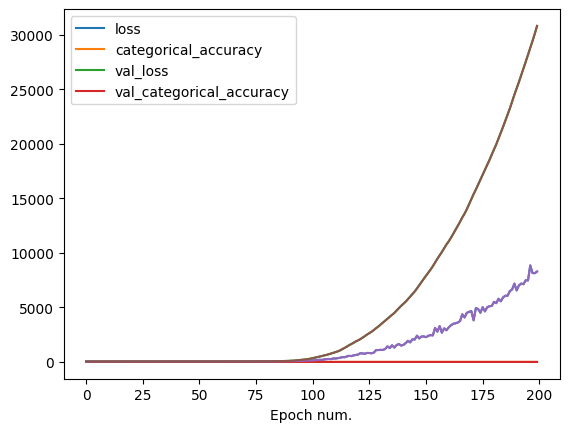

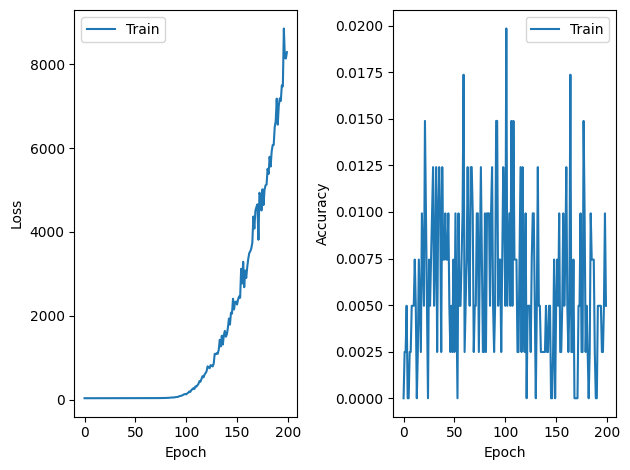

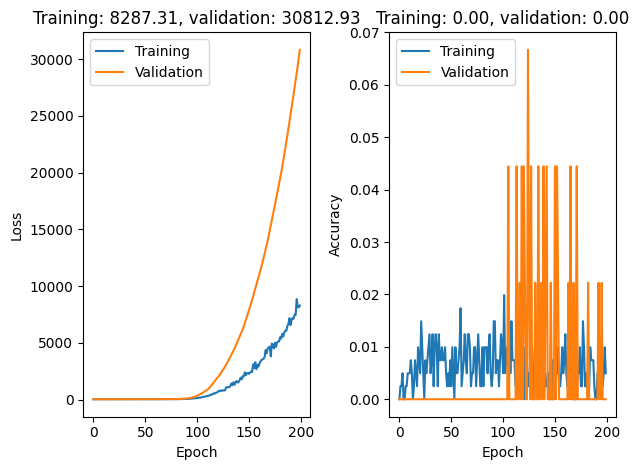

In [176]:
pd.DataFrame(cnn_history.history).plot()
plt.plot(cnn_history.history['loss'], label='Train loss')
plt.plot(cnn_history.history['val_loss'], label='Val. loss')
plt.xlabel('Epoch num.')
plt.show()

plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['loss'], label='Train')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['categorical_accuracy'], label='Train')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['loss'], label='Training')
plt.plot(cnn_history.history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Training: {cnn_history.history["loss"][-1]:.2f}, validation: {cnn_history.history["val_loss"][-1]:.2f}')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['categorical_accuracy'], label='Training')
plt.plot(cnn_history.history['val_categorical_accuracy'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Training: {cnn_history.history["categorical_accuracy"][-1]:.2f}, validation: {cnn_history.history["val_categorical_accuracy"][-1]:.2f}')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
#cnn_loss, cnn_acc = model.evaluate(entradaTestIndicesNormalizados, salidaEsperadaCompressedTest)

Ahora tras haberlo entrenado lo guardamos

In [ ]:
#perceptronMulticape = tf.keras.Sequential() # TO-DO hacer el perceptrón multicapa por separado tras entrenar la convolucion

model.save("cnn-Algigantix.h5") # guardar
tf.keras.load_model("cnn-Algigantix.h5") # cargar 

#

#
#model.summary()
#
#
#history = model.fit(
# TO-DO
#
#)
#
#test_loss, test_acc = model.evaluate(x_test, y_test)

In [138]:
checkpointRecurrent = tf.keras.callbacks.ModelCheckpoint(
    'rnn-Algigantix/model-{loss:.4f}.h5',
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

In [157]:
# FASE 3 RRNN RECURRENTE
print("hello")

input_ = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(x)
#x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1648, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(len(matrizSalidaSinKeywords), activation='sigmoid')(x)

modelRRRNN = tf.keras.Model(input_, output)

modelRRRNN.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()]
)

modelRRRNN.summary()

hello
Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 333)]             0         
                                                                 
 embedding (Embedding)       (None, 333, 200)          1351400   
                                                                 
 bidirectional_17 (Bidirecti  (None, 333, 256)         253440    
 onal)                                                           
                                                                 
 dropout_43 (Dropout)        (None, 333, 256)          0         
                                                                 
 flatten_12 (Flatten)        (None, 85248)             0         
                                                                 
 dropout_44 (Dropout)        (None, 85248)             0         
                                                    

In [158]:
rnn_history = modelRRRNN.fit(
    #entradaEntrenadaAjustada,
    #entradaEntrenamientoIndicesNormalizados,
    data,
    salidaEsperadaCompressedAjustada,
    epochs=10,
    validation_split=0.1,
    callbacks=[checkpointRecurrent]
)

Epoch 1/50
13/13 [==============================] - 24s 2s/step - loss: 43.0554 - categorical_accuracy: 0.0050 - val_loss: 36.2144 - val_categorical_accuracy: 0.0000e+00
Epoch 2/50
13/13 [==============================] - 18s 1s/step - loss: 30.6103 - categorical_accuracy: 0.0819 - val_loss: 36.5901 - val_categorical_accuracy: 0.0000e+00
Epoch 3/50
13/13 [==============================] - 18s 1s/step - loss: 23.1425 - categorical_accuracy: 0.1191 - val_loss: 37.2450 - val_categorical_accuracy: 0.0000e+00
Epoch 4/50
13/13 [==============================] - 20s 2s/step - loss: 19.0999 - categorical_accuracy: 0.1861 - val_loss: 37.4936 - val_categorical_accuracy: 0.0000e+00
Epoch 5/50
13/13 [==============================] - 17s 1s/step - loss: 21.4129 - categorical_accuracy: 0.2184 - val_loss: 42.0886 - val_categorical_accuracy: 0.0000e+00
Epoch 6/50
13/13 [==============================] - 18s 1s/step - loss: 32.5615 - categorical_accuracy: 0.1886 - val_loss: 84.7326 - val_categorical_a

KeyboardInterrupt: 

In [160]:
pd.DataFrame(rnn_history.history).plot()
plt.plot(rnn_history.history['loss'], label='Train loss')
plt.plot(rnn_history.history['val_loss'], label='Val. loss')
plt.xlabel('Epoch num.')
plt.show()

plt.subplot(1, 2, 1)
plt.plot(rnn_history.history['loss'], label='Train')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(rnn_history.history['categorical_accuracy'], label='Train')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

plt.subplot(1, 2, 1)
plt.plot(rnn_history.history['loss'], label='Training')
plt.plot(rnn_history.history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Training: {rnn_history.history["loss"][-1]:.2f}, validation: {rnn_history.history["val_loss"][-1]:.2f}')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(rnn_history.history['categorical_accuracy'], label='Training')
plt.plot(rnn_history.history['val_categorical_accuracy'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Training: {rnn_history.history["categorical_accuracy"][-1]:.2f}, validation: {rnn_history.history["val_categorical_accuracy"][-1]:.2f}')
plt.legend()

plt.tight_layout()
plt.show()

NameError: name 'rnn_history' is not defined

In [ ]:
rnn_loss, rnn_acc = model.evaluate(modelRRRNN, salidaEsperadaCompressedTest)